### Association Networks

#### Binning Schemes

Events can be grouped with a typical value interval, the so-called binning size. Binning generation can be performed in alternative ways, allowing us to put the hypothetically created constraints into practice.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import functions as fn
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
df_PLTCM = pd.read_csv('data/pltcm_manipulated_59604_rev1.csv', header=None)
pd.read_csv('data/pltcm_manipulated_59604_rev1.csv', names=fn.columns_PLTCM, header=None)

,EVENT_ID,PROGRAM_ID,1,2,3,4,5,6,INPUT_WIDTH,INPUT_THICKNESS,...,TARGET_WIDTH,THICKNESS_HSM,THICKNESS,TRIM_WIDTH,WIDTH,MATERIAL_ID,PIECE_ID,WEIGHT,LENGTH,INPUT_LENGTH
0,1,3609,0,0,0,0,0,0,1264.0446,2.55459,...,1222.6404,2.55459,0.477354,1224.67,1222.6381,318580,17167961-03000,13.57540,2998.57,543.95600
1,2,3609,0,0,0,0,0,0,1129.5043,2.73491,...,1089.0250,2.73491,0.564271,1091.06,1089.0281,323346,17172941-01000,21.04121,4387.14,875.23380
2,3,3609,0,0,0,0,0,0,1096.1252,2.71956,...,1057.3627,2.71956,0.614289,1059.39,1057.3580,323357,17172961-04000,15.52353,3061.01,672.14825
3,4,3609,0,0,0,0,0,0,1129.7084,2.73506,...,1089.0250,2.73506,0.564197,1091.06,1089.0281,323344,17172921-05000,21.02293,4386.41,875.66516
4,5,3609,0,0,0,0,0,0,1569.3829,2.63399,...,1528.7625,2.63399,0.569115,1529.56,1528.7650,318740,17168341-04000,17.28409,2558.96,536.53850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59599,59600,22800,0,0,0,0,0,0,1261.3135,5.00986,...,1222.3738,5.00986,1.431855,1222.90,1222.3717,1117991,20165941-06000,17.57078,1271.65,371.10983
59600,59601,22800,0,0,0,0,0,0,1261.1356,4.65018,...,1222.3738,4.65018,1.146508,1222.90,1222.3717,1117999,20165961-07000,17.78187,1612.51,404.14432
59601,59602,22800,0,0,0,0,0,0,1263.5488,2.73054,...,1212.2137,2.73054,0.512399,1212.74,1212.2117,1118016,20166001-07000,17.53634,3656.06,685.52203
59602,59603,22800,0,0,0,0,0,0,1280.8510,2.52041,...,1242.1870,2.52041,0.470304,1245.74,1242.1840,1117987,20165941-02000,20.33075,4472.55,840.73800


There alternative ways of binning such as fixed steps or fixed counts (buckets). The former creates binning with defined step size, the latter forms bin data into groups with equal numbers of elements.

The alternative binning generation methods mentioned above will let us derive two distinguished approaches to construct association networks.

In [3]:
#df = df_PLTCM
feature = 8 # input width
df = pd.DataFrame()
df['sequence_id'] = df_PLTCM[1]
df[feature] = df_PLTCM[feature]
df['bins_fxd_step'] = fn.binning_fxd_step(df_PLTCM[feature], 11)
df['bins_fxd_bucket'] = fn.binning_fxd_count(df_PLTCM[feature], 200)
print('bins_fxd_step count:',df['bins_fxd_step'].nunique())
print('bins_fxd_bucket count:',df['bins_fxd_bucket'].nunique())
df
# select specific rows for testing
#df.iloc[[73,472,1213,9087], [0,2]]

bins_fxd_step count: 85
bins_fxd_bucket count: 194


,sequence_id,8,bins_fxd_step,bins_fxd_bucket
0,3609,1264.0446,"(1258, 1269)","(1263, 1265)"
1,3609,1129.5043,"(1126, 1137)","(1127, 1131)"
2,3609,1096.1252,"(1093, 1104)","(1094, 1098)"
3,3609,1129.7084,"(1126, 1137)","(1127, 1131)"
4,3609,1569.3829,"(1566, 1577)","(1569, 1570)"
...,...,...,...,...
59599,22800,1261.3135,"(1258, 1269)","(1260, 1262)"
59600,22800,1261.1356,"(1258, 1269)","(1260, 1262)"
59601,22800,1263.5488,"(1258, 1269)","(1263, 1264)"
59602,22800,1280.8510,"(1280, 1291)","(1280, 1282)"


#### Lift Measure

We extract the association rule from the set of production sequences to distinguish statistically unexpected occurrences from the non-random ones in production sequences and assess the complexity of production patterns.

The Lift can be computed as the ratio of pair items joint
probability divided by the multiplication of each item’s marginal probability as:

$$ Lift(A ↔ B) =  \frac{P(A, B)}{P(A) ∗ P(B)} $$

If the lift is higher than 1, B likely occurs when A occurs. If the lift is lower than 1, B unlikely occurs when A occurs.

In [4]:
# Calculate lift and get indices for both fixed-step bins and fixed-count buckets
lift_pairwise_step, elem_map_step = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_step', return_element_mapping=True)
lift_pairwise_bucket, elem_map_bucket = fn.calculate_lift_pairwise(df, bins_column='bins_fxd_bucket', return_element_mapping=True)

# Build adjacency matrices
adj_matrix_step = fn.create_adjacency_matrix(lift_pairwise_step, elem_map_step)
adj_matrix_bucket = fn.create_adjacency_matrix(lift_pairwise_bucket, elem_map_bucket)

In [9]:
#lift_pairwise_step
#lift_pairwise.index.to_list()

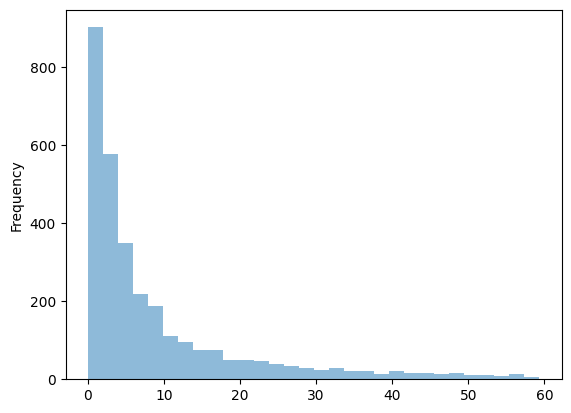

In [11]:
#histogram
ax = lift_pairwise_step['lift_value'].apply(lambda x: x if 0 < x < 60 else None).plot.hist(bins=30, alpha=0.5)

Characteristics:
- Right-Skewed, approaching zero
- Heavy concentration at low lift values (0-5)
- Long tail toward higher values
- High positive skewness (> 1.0)
- Median << Mean

What it means:
- High-Frequency Elements: Most element pairs have weak or random co-occurrence
- Most pairs have lift < 1 (appear together less often than random chance)
- A few rare pairs have strong associations
- Common elements occur independently; co-occurrence is mostly coincidental

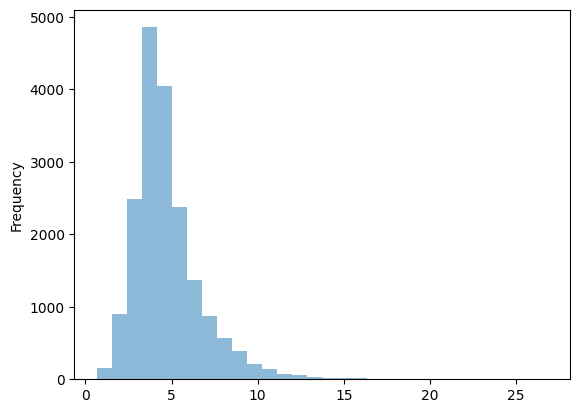

In [10]:
bx = lift_pairwise_bucket['lift_value'].apply(lambda x: x if 0 < x < 5000 else None).plot.hist(bins=30, alpha=0.5)

Characteristics:
- Near-Normal, deviation from zero
- More centered distribution (peak around 2-3)
- Roughly symmetric around the mean
- Lower skewness (-0.5 to +0.5)
- Mean ≈ Median

What it means:
- Rare/Selective Elements: Most element pairs have meaningful associations
- Lift values are concentrated around 2-4 (strong positive associations)
- More consistent clustering behavior
- Rare elements form predictable, structured groups when they co-occur

### Network Analysis

Constructing FSS (Fixed Step Size) and FBS (Fixed Bucket Size) networks for the production events concerning technology-driven constraints and load-driven constraints underlie the developed hypothesis of this work: Non-random features of the association networks derived from these two approaches.

The first one, the FSS Network has graph nodes as binning groups with equal bin sizes. Manipulation of binning size allows us to aggregate events in different network nodes. 

The FBS Network is the second one where the network nodes are binning groups with an equal number of events per bin. Defining a typical bucket size for the network nodes results in arbitrary interval boundaries for each node, and it allows to control their population.

#### Graphs Generation

In [8]:
adj_matrix_step
# select specific pair
# lift_pairwise.loc[(lift_pairwise['element_A_row_idx'] == 0) & (lift_pairwise['element_B_row_idx'] == 5)]

,0,1,2,4,5,6,7,8,13,14,...,6585,8553,8636,9087,11931,13191,15184,15259,15566,30000
0,1.000000,0.126610,0.163488,0.055177,7.243478,2.711224,1.171064,0.222892,0.064400,0.296319,...,0.794165,1.542305,16.6093,20.346350,1.647842,0.575741,94.672750,3.832921,21.49430,4.235340
1,0.126610,1.000000,0.589535,0.104108,20.594450,4.243680,5.797854,0.657925,0.139816,1.128944,...,1.697376,3.086633,0.0000,5.616700,8.786167,0.319200,89.866567,7.632900,2.64310,1.872200
2,0.163488,0.589535,1.000000,0.150094,7.078833,4.375113,7.124540,0.413793,0.205579,1.428879,...,3.272315,3.749880,9.4385,0.000000,6.354250,0.594180,84.946300,15.609800,3.33120,4.719200
4,0.055177,0.104108,0.150094,1.000000,7.214325,2.349281,1.608057,0.284048,0.060672,0.387064,...,0.904758,1.780874,23.0858,22.071043,1.132625,0.978164,26.637450,10.764273,8.02258,5.993437
5,7.243478,20.594450,7.078833,7.214325,1.000000,275.944425,170.239900,18.373600,6.838178,31.086925,...,70.620850,83.902000,0.0000,620.875000,107.553175,65.141000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13191,0.575741,0.319200,0.594180,0.978164,65.141000,5.428400,7.880000,2.630550,0.607440,1.630800,...,7.100700,19.806400,65.1410,195.423000,11.540700,1.000000,0.000000,176.632250,34.48640,56.998375
15184,94.672750,89.866567,84.946300,26.637450,0.000000,1103.777800,0.000000,48.996300,14.855400,276.328200,...,188.322300,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,1528.307700,0.00000,0.000000
15259,3.832921,7.632900,15.609800,10.764273,0.000000,127.359000,0.000000,11.306833,2.816008,15.486514,...,43.459000,77.448000,0.0000,859.673100,54.152600,176.632250,1528.307700,1.000000,0.00000,668.634600
15566,21.494300,2.643100,3.331200,8.022580,0.000000,0.000000,0.000000,17.292800,9.587300,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,34.486400,0.000000,0.000000,1.00000,0.000000


#### Modularity Measure

#### Randomness Control with Different Null Models